# Exploring MESA models

Let's look at the output from the [MESA stellar evolution code](https://docs.mesastar.org/) for 3 different mass progenitors: 1, 8, and 15 $M_\odot$.
These models were all created using [MESA Web](http://user.astro.wisc.edu/~townsend/static.php?ref=mesa-web-submit) a web-based interface to MESA
for quick calculations.

To read in these files, we use [py_mesa_reader](https://github.com/wmwolf/py_mesa_reader)

````{note}
`py_mesa_reader` is not available on PyPI, so it can be installed using `pip` as:
```
pip install git+https://github.com/wmwolf/py_mesa_reader
```
````

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mesa_reader as mr

MESA provides 2 types of output: profiles and a history.  The profiles represent a snapshot of the start at one instance of time and give the stellar data as a function of radius or enclosed mass.  The history provides some global quantities as a function of time throughout the entire evolution of the star.  We'll use both.

The model files are:

* $1 M_\odot$: [M1_default_profile8.data](M1_default_profile8.data); [M1_default_profile218.data](M1_default_profile218.data); [M1_default_trimmed_history.data](M1_default_trimmed_history.data)

* $8 M_\odot$: [M8_basic_co_profile8.data](M8_basic_co_profile8.data); [M8_basic_co_profile39.data](M8_basic_co_profile39.data); [M8_basic_co_trimmed_history.data](M8_basic_co_trimmed_history.data)

* $15 M_\odot$: [M15_aprox21_profile8.data](M15_aprox21_profile8.data); [M15_aprox21_profile19.data](M15_aprox21_profile19.data); [M15_aprox21_trimmed_history.data](M15_aprox21_trimmed_history.data)

To make the management easier, we'll create a container for each model that holds the history and profiles, processed by `py_mesa_reader`

In [2]:
class Model:
    def __init__(self, mass, profiles=None, history=None):
        self.mass = mass
        if history:
            self.history = mr.MesaData(history)
        self.profiles = []
        if profiles:
            for p in profiles:
                self.profiles.append(mr.MesaData(p))

Now read in all the data.  For each mass we have 2 profiles and 1 history.  The profiles were picked to roughly correspond to the midpoint of core H burning and core He burning.

In [3]:
models = []

models.append(Model(1, profiles=["M1_default_profile8.data",
                                 "M1_default_profile218.data"],
                    history="M1_default_trimmed_history.data"))

models.append(Model(8, profiles=["M8_basic_co_profile8.data",
                                 "M8_basic_co_profile39.data"],
                    history="M8_basic_co_trimmed_history.data"))

models.append(Model(15, profiles=["M15_aprox21_profile8.data",
                                  "M15_aprox21_profile19.data"],
                    history="M15_aprox21_trimmed_history.data"))

## HR diagram

Now we'll make an HR diagram and label the points where $H$ and $He$ burning commences.

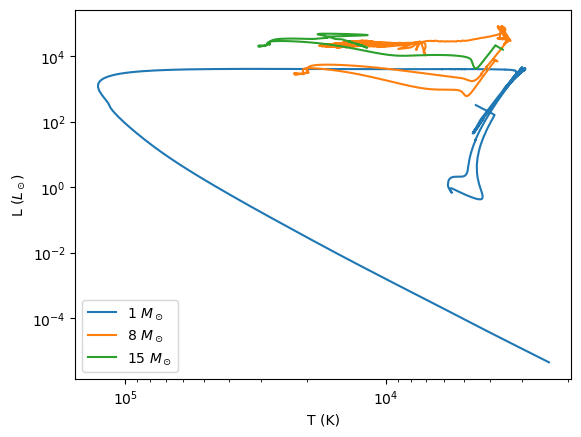

In [4]:
fig, ax = plt.subplots()

for star in models:
    ax.loglog(star.history.Teff, star.history.L,
              label=rf"{star.mass} $M_\odot$")

ax.legend()
ax.set_xlabel("T (K)")
ax.set_ylabel(r"L ($L_\odot$)")
ax.invert_xaxis()

You can see the main sequence clearly on this plot.

We also see that only the 1 solar mass star "finished' stellar evolution, winding up as a cooling white dwarf at the end -- the path it is following is essentially a line of constant radius, since the white dwarf does not contract as it cools (it is degenerate).

## Central evolution

We want to plot the history of the evolution of the central conditions  in the $\log \rho$-$\log T$ plane.

We will plot the EOS boundary lines considered before.  These
functions are now in a module, [regimes.py](regimes.py) to make our life easier.

In [5]:
import regimes

Now we can plot the data

(100000.0, 1000000000.0)

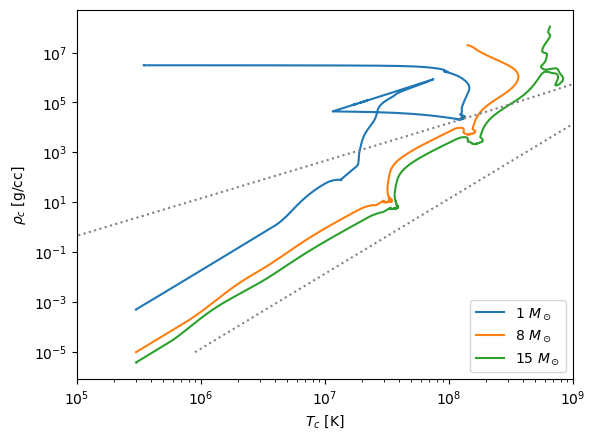

In [6]:
fig, ax = plt.subplots()

for star in models:
    ax.loglog(star.history.center_T, star.history.center_Rho,
              label=rf"{star.mass} $M_\odot$")

rho = np.logspace(-5, 8, 100)
ax.loglog(regimes.deg_ideal(rho, mu_e=1.3), rho, color="0.5", ls=":")
ax.loglog(regimes.rad_ideal(rho, mu=0.6), rho, color="0.5", ls=":")
ax.legend()

ax.set_xlabel(r"$T_c$ [K]")
ax.set_ylabel(r"$\rho_c$ [g/cc]")

ax.set_xlim(1.e5, 1.e9)

Some observations:

* The higher mass stars are closer to the line where radiation dominates.
* The 1 solar mass star makes a transition from following $T \approx \rho^{1/3}$ to $\rho = \mbox{constant}$ when degeneracy kicks in.
* The other stars more or less follow the $T \approx \rho^{1/3}$ trend expected from polytropes + ideal gas.


## Main sequence lifetime

We can estimate the main sequence lifetime just by looking for when the core H is all consumed.

(10000.0, 20000000000.0)

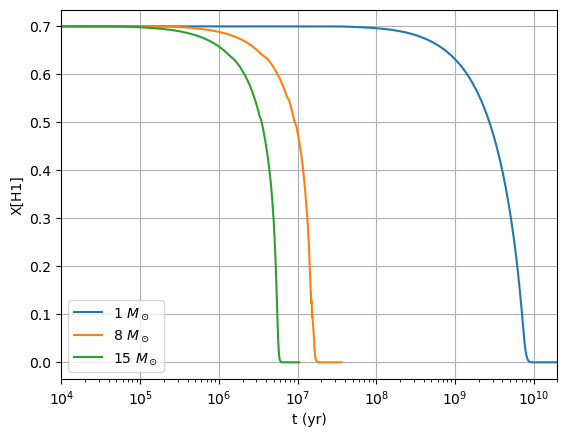

In [7]:
fig, ax = plt.subplots()
for star in models:
    ax.semilogx(star.history.star_age, star.history.center_h1, label=rf"{star.mass} $M_\odot$")
ax.legend()
ax.set_xlabel("t (yr)")
ax.set_ylabel("X[H1]")
ax.grid()
ax.set_xlim(1.e4, 2.e10)

From this plot, we see that the main sequence lifetime of the 15 $M_\odot$ star is $\sim 6\times 10^6$ yr, for the 8 $M_\odot$ star $\sim 2\times 10^7$ yr, and for the 1 $M_\odot$ star $\sim 9\times 10^9$ yr.

## Profiles 

Let's next look at the profiles of the stars in the $\log \rho$-$\log T$ plane

First the 1 solar mass star

(1000.0, 1000000000.0)

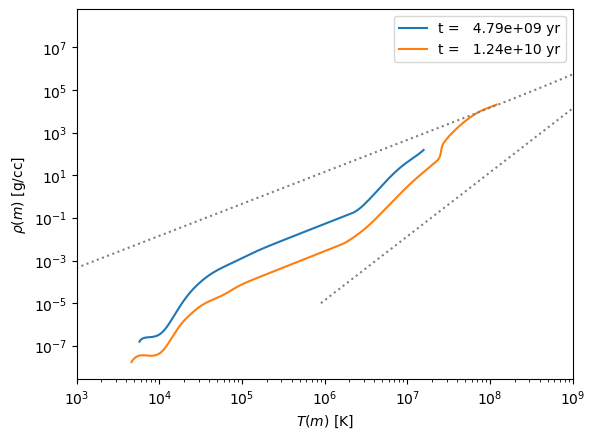

In [8]:
fig, ax = plt.subplots()

for p in models[0].profiles:
    ax.plot(p.T, p.Rho, label=f"t = {p.star_age:10.3g} yr")

ax.loglog(regimes.deg_ideal(rho, mu_e=1.3), rho, color="0.5", ls=":")
ax.loglog(regimes.rad_ideal(rho, mu=0.6), rho, color="0.5", ls=":")
ax.legend()

ax.set_xlabel(r"$T(m)$ [K]")
ax.set_ylabel(r"$\rho(m)$ [g/cc]")

ax.set_xlim(1.e3, 1.e9)

Now the 8 solar mass star

(1000.0, 1000000000.0)

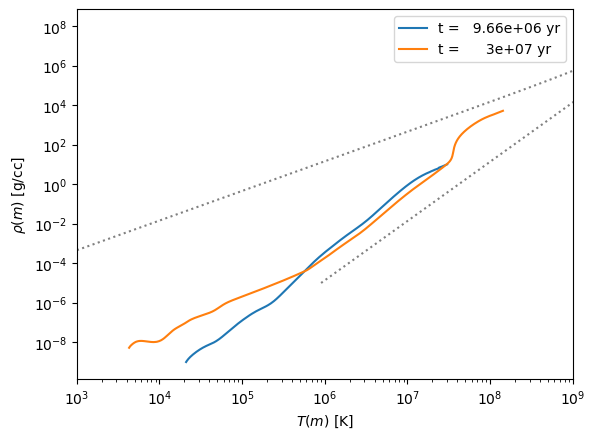

In [9]:
fig, ax = plt.subplots()

for p in models[1].profiles:
    ax.plot(p.T, p.Rho, label=f"t = {p.star_age:10.3g} yr")

ax.loglog(regimes.deg_ideal(rho, mu_e=1.3), rho, color="0.5", ls=":")
ax.loglog(regimes.rad_ideal(rho, mu=0.6), rho, color="0.5", ls=":")
ax.legend()

ax.set_xlabel(r"$T(m)$ [K]")
ax.set_ylabel(r"$\rho(m)$ [g/cc]")

ax.set_xlim(1.e3, 1.e9)

Finally the 15 solar mass star

(1000.0, 1000000000.0)

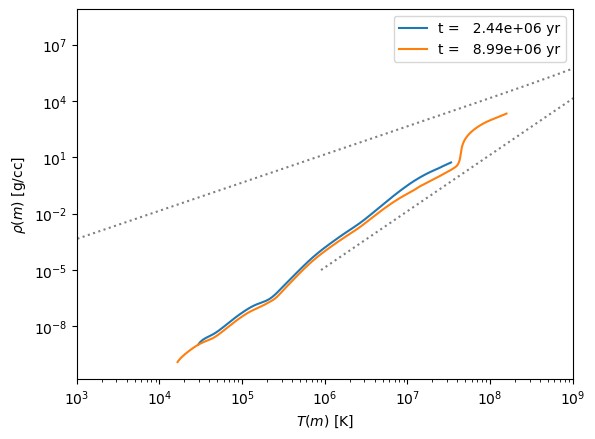

In [10]:
fig, ax = plt.subplots()

for p in models[2].profiles:
    ax.plot(p.T, p.Rho, label=f"t = {p.star_age:10.3g} yr")

ax.loglog(regimes.deg_ideal(rho, mu_e=1.3), rho, color="0.5", ls=":")
ax.loglog(regimes.rad_ideal(rho, mu=0.6), rho, color="0.5", ls=":")
ax.legend()

ax.set_xlabel(r"$T(m)$ [K]")
ax.set_ylabel(r"$\rho(m)$ [g/cc]")

ax.set_xlim(1.e3, 1.e9)

## Convection

We can look at where the models are convective by comparing $\nabla$ and $\nabla_\mathrm{ad}$.

First the H burning profiles

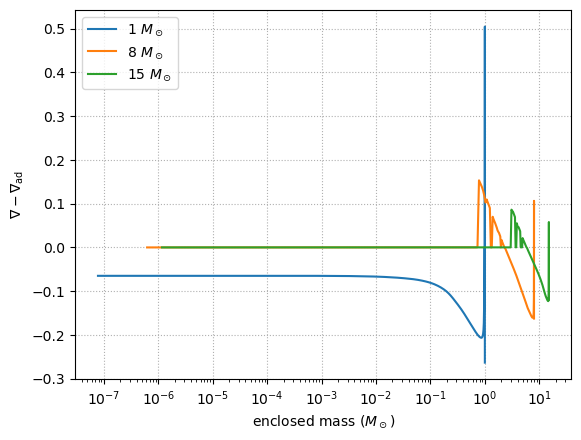

In [11]:
fig, ax = plt.subplots()

for star in models:
    ax.plot(star.profiles[0].mass, star.profiles[0].gradT - star.profiles[0].grada,
            label=rf"{star.mass} $M_\odot$")

ax.set_xlabel(r"enclosed mass ($M_\odot$)")
ax.set_ylabel(r"$\nabla - \nabla_\mathrm{ad}$")
ax.set_xscale("log")
ax.legend()
ax.grid(linestyle=":")

We see that the massive stars have convective cores $\nabla \sim \nabla_\mathrm{ad}$, but the 1 solar mass star has a radiative core.

Let's look at the same plot, but in terms of radius

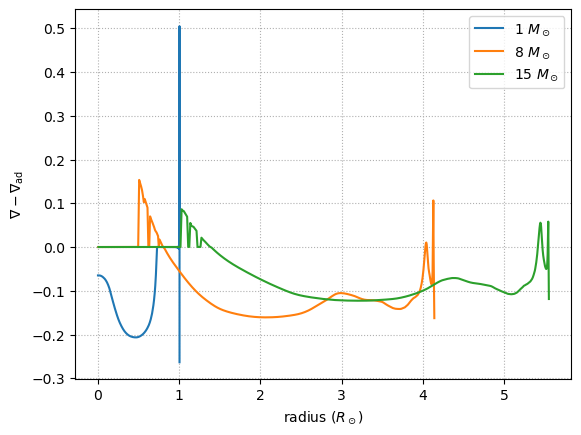

In [13]:
fig, ax = plt.subplots()

for star in models:
    ax.plot(star.profiles[0].radius, star.profiles[0].gradT - star.profiles[0].grada,
            label=rf"{star.mass} $M_\odot$")

ax.set_xlabel(r"radius ($R_\odot$)")
ax.set_ylabel(r"$\nabla - \nabla_\mathrm{ad}$")
#ax.set_xscale("log")
ax.legend()
ax.grid(linestyle=":")

On this scale, we see that the Sun's outer convective zone is ~ 1/3rd of its radius